<div style="
    border: 2px solid #4CAF50; 
    padding: 15px; 
    background-color: #f4f4f4; 
    border-radius: 10px; 
    align-items: center;">

<h1 style="margin: 0; color: #4CAF50;">Weitere Datenformen</h1>
<h2 style="margin: 5px 0; color: #555;">DSAI</h2>
<h3 style="margin: 5px 0; color: #555;">Jakob Eggl</h3>

<div style="flex-shrink: 0;">
    <img src="https://www.htl-grieskirchen.at/wp/wp-content/uploads/2022/11/logo_bildschirm-1024x503.png" alt="Logo" style="width: 250px; height: auto;"/>
</div>
<p1> © 2024/25 Jakob Eggl. Nutzung oder Verbreitung nur mit ausdrücklicher Genehmigung des Autors.</p1>
</div>
<div style="flex: 1;">
</div>   

Teile dieses Notebooks (adaptiert) aus Hands-On AI 1 WS21; JKU

---

Bisher haben wir uns hauptsächlich mit tabellarischen Daten beschäftigt. Dabei wurden insbesondere folgende Themen durchgemacht:
* **Vorverarbeitungsschritte** (Normalisierung, Fehlende Werte, Data Cleaning, etc.)
* **Statistiken**
* **Visualisierungen**


Nun beschäftigen wir uns mit **anderen Formen von Daten**, welche, je nach Anwendungsfall, auch in vielen Gebieten im Machine Learning auftreten.

## Bilder

Bilder besitzen normalerweise 3 Dimensionen.

Die 3 Dimension sind dabei $\text{height}\times\text{length}\times \text{channels}$.

Dabei ist die letzte Dimension (*channels*) zuständig für die Farben eines jedes einzelnen Pixels. (*RGB*, sprich *Rot*, *Grün* und *Blau*).

In Python können wir uns diese Dimensionen anzeigen lassen. Dafür laden wir zuerst einmal ein Bild.

Wir benötigen die `cv2` library. Wir installieren sie mit `conda install -c conda-forge opencv`.

Außerdem benötigen wir die `spacy` library. Wir installieren sie mit `conda install -c conda-forge spacy`. (siehe https://spacy.io/usage für andere Betriebssysteme, Prozessorarchitekturen und/oder Sprachen)

In [1]:
import os
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.image import imread
import numpy as np
from PIL import Image
from scipy import ndimage
import cv2
import scipy
from scipy.ndimage import gaussian_filter
from sklearn.decomposition import PCA
import IPython.display as ipd
from scipy.io.wavfile import read
from typing import Tuple, Union
import spacy
import glob

In [2]:
def plot_image(image_path: str):
    img = imread(image_path)
    plt.imshow(img)
    plt.axis('off') # turn off axis
    plt.show()


In [3]:
image_path = os.path.join("..", "resources", "Columbus.jpg")

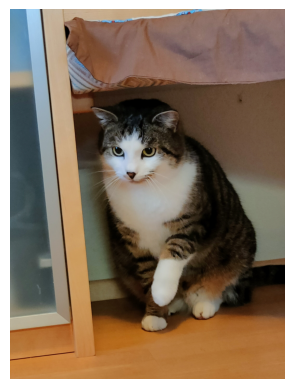

In [4]:
plot_image(image_path)

In unserem Fall können wir auch die Dimensionen ausgeben. Dies passiert mit dem `imread(path).shape` Befehl.

In [5]:
img = imread(image_path)
shape = img.shape # height x width x color channels

print(shape)

(3087, 2289, 3)


Eine weitere wichtige Eigenschaft ist die Farbtiefe von Bildern. Normalerweise haben wir eine $8$ Bit Farbtiefe pro Farbe. Sprich pro Channel sind $2^8=256$ verschiedene Farben möglich.

In manchen Fällen haben Bilder aber auch eine $16$ Bit Farbtiefe. Hier gibt es dann $2^{16}=256\cdot 256 = 65536$ verschiedene Farben pro Channel.

Wie viele mögliche Farben gibt es also insgesamt? Und wie viele mögliche Bilder resultieren daraus?

### RGB Model

In unserem Fall besitzt das Bild 3 Kanäle mit einer Farbtiefe von jeweils 8 Bit. Wir können diese Kanäle nun etwas genauer untersuchen.

In [6]:
channel = 'green' # 'green', 'blue'

if channel == 'red':
    channel = 0
elif channel == 'green':
    channel = 1
elif channel == 'blue':
    channel = 2
else:
    raise ValueError(f"Invalid channel: {channel}")

img = imread(image_path)
print(f"Minimum: {np.min(img[:,:,channel])}")
print(f"Maximum: {np.max(img[:,:,channel])}")

Minimum: 0
Maximum: 234


Das RGB Model wird als **additives Farbmodel** bezeichnet, da die 3 Kanäle in **Summe** das gesamte Bild erzeugen.

In [7]:
def plot_image_channels_rgb(image_path: str):
    
    img = imread(image_path)
    fig, ax = plt.subplots(1, 3, figsize=(15, 10))
    channels = [0, 1, 2]
    colors = ['red', 'green', 'blue']
    
    for channel, channel_name in zip(channels, colors):
        tmp = np.zeros(img.shape, dtype='uint8')
        tmp[:, :, channel] = img[:, :, channel]
        ax[channel].imshow(tmp)
        ax[channel].set_title(channel_name + ' channel')
        ax[channel].axis(r'off')

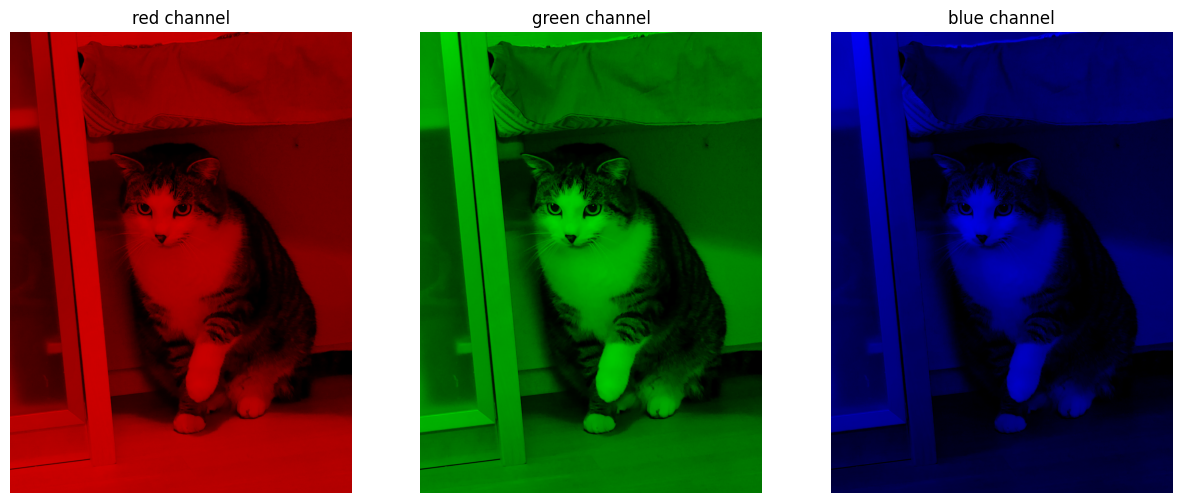

In [8]:
plot_image_channels_rgb(image_path)

In [9]:
def plot_rgb_histograms(image_path: str, bins:int=255):
    img = imread(image_path)
    fig, ax = plt.subplots(1, 3, figsize=(15, 3))
    colors = ['red', 'green', 'blue']
    for i, color in enumerate(colors):
        ax[i].hist(img[:, :, i].ravel(), bins=bins, histtype=r'stepfilled', density=True, color=color)


In [10]:
plot_rgb_histograms(image_path, bins=50) # default bins = 255

### RGBA Model

In vielen Bildern gibt es einen weiteren Channel, welcher die *Transparenz* darstellt. Dabei steht das *A* im Modell für *alpha*. Die Werte sind dabei gleich wie bei den anderen 3 Kanälen. Wir können aber auch einen Prozentwert vergeben.

In [11]:
def plot_image_rgba(image_path: str, alpha: float = 1.0):
    with Image.open(image_path) as img:
        img = img.convert(r'RGBA')
        int_alpha = int(256 * alpha)
        img.putalpha(int_alpha)
        plt.imshow(img)
        plt.axis('off')
        plt.show()

In [12]:
plot_image_rgba(image_path, alpha=0.5)

### Graustufen

Eine weitere Variante sind die sogenannten Schwarz-Weiß bzw. Graustufen Bilder. Dabei gibt es nur einen Channel, der die Helligkeit im Bild repräsentiert. Das Umwandeln in ein Graustufen Bild ist einfach, umgekehrt geht das ohne zusätzliche Information nicht. Wieso?

In [13]:
def plot_image_grayscale(image_path: str):
    with Image.open(image_path) as img:
        img = img.convert(mode='1') # mode '1' for grayscale image.
        plt.imshow(img)
        plt.axis('off')
        plt.show()

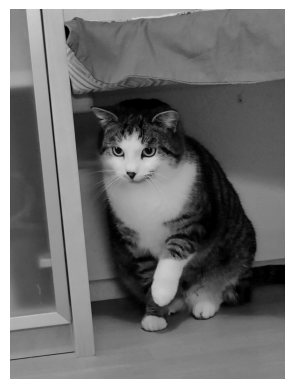

In [14]:
plot_image_grayscale(image_path)

Wo könnten Graustufen Bilder helfen?
* Bild Klassifizierung (zBsp Auto/Motorrad Unterscheidung) Warum ist dies für Modelle eventuell vom Vorteil?
* Speicherplatzreduzierung

### Data Augmentation (=Daten Erweiterung)

In weiterer wichtiger Punkt ist die sogenannte *Data Augmentation*, sprich die Datenerweiterung. Dabei geht es darum aus einem bestehenden Dataset weitere Daten zu produzieren.

Annahme, wir wollen nun einen Klassifizierer bauen, welcher zwischen Bildern, auf denen sich die Katze *Columbus* befindet, und Bildern, wo sich die Katze nicht befindet, unterscheiden kann. Dazu würden wir zum Trainieren dieses Modells jetzt noch viele weitere Fotos von Columbus brauchen (und auch viele ohne Columbus). Um den großen Aufwand der Datenbeschaffung zu reduzieren können wir nun Data Augmentation verwenden.

(Wichtig: Hier soll der Klassifizierer **nicht** in einer großen Datenbank einfach Fotos vergleichen sondern er soll wirklich das Konzept einer Katze lernen und auch neue, noch nie gesehene, Fotos richtig zuordnen können in die Kategorien *Katze* und *Keine Katze*)

**Möglichkeiten zur Daten Erweiterung:**
* Rotation
* Spiegeln
* Zuschneiden
* Sharpening/Blurring
* Graustufen
* Resizing

### Rotation

* Einfache Möglichkeit, weitere Daten zu generieren
* Ob und wie sehr rotiert werden kann/soll hängt von der Anwendung ab (Katzenbilder vs. Autobilder: Autos werden 180° gedreht wenig Sinn machen, Katzen auch nur manchmal)

In [15]:
def plot_rotated_image(image_path: str, angle):
    img = imread(image_path)
    img_rotated = ndimage.rotate(img, angle=angle)
    plt.imshow(img_rotated)
    plt.axis('off')
    plt.show()

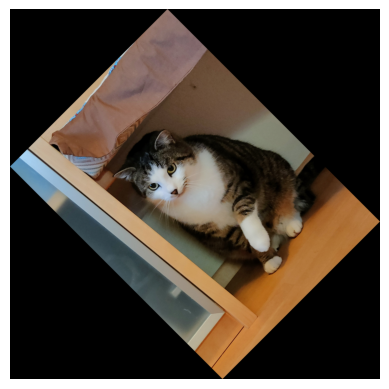

In [16]:
plot_rotated_image(image_path, angle=45)

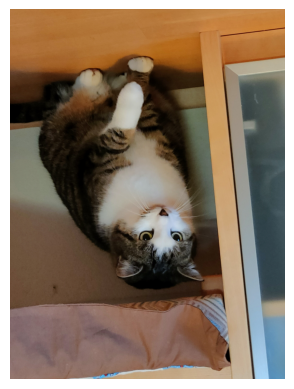

In [17]:
plot_rotated_image(image_path, angle=180)

### Spiegeln

* Sehr ähnlich (aber nicht gleich) zum Rotieren
* Auch hier nicht bei jedem Bild anwendbar

In [18]:
def plot_flipped_image(image_path: str, flipping: str):
    img = imread(image_path)
    if flipping == 'horizontal':
        plt.imshow(img[:, ::-1, :])
    elif flipping == 'vertical':
        plt.imshow(img[::-1, :, :])
    plt.gca().axis(r'off')
    plt.show()

In [19]:
plot_flipped_image(image_path, flipping=r'vertical')

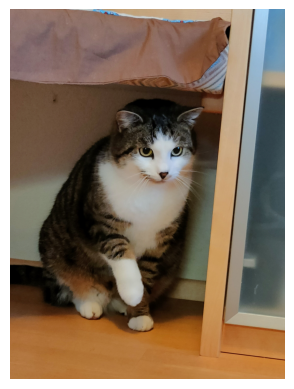

In [20]:
plot_flipped_image(image_path, flipping=r'horizontal')

### Zuschneiden

* Weitere einfache Möglichkeit, Daten zu generieren
* Kann (fast) beliebig angewendet werden (zu großes oder kleines Objekt unbrauchbar)
* muss danach wieder die selben Dimensionen haben!

In [21]:
def plot_cropped_image(image_path: str, left, top, width, height):
    with Image.open(image_path) as img:
        img_cropped = img.crop((left, top, left + width, top + height)) # 
        plt.imshow(img_cropped)
        plt.gca().axis(r'off')
        plt.show()
    return img_cropped

In [22]:
img_cropped = plot_cropped_image(image_path, left=1000, top=1000, width=300, height=300) # Macht dieses Bild Sinn?

In [23]:
print(img_cropped.size) # Achtung: Shape ist nun anders als bei vorigen Bilder. Normalerweise wollen wir (lernen wir später/nächstes Jahr) gleiche Größe behalten -> siehe Resizing

(300, 300)


### Unschärfen/Schärfen (Blurring/Sharpening)

Da auch echte Fotos nicht immer gleich scharf/verschwommen sind, kann es auch hilfreich sein, die Fotos künstlich etwas Unscharf zu machen bzw. zu schärfen.
Wichtig dabei ist:
* Fotos, die zu unscharf sind, sind unbrauchbar
* Ebenso sind "zu scharfe" Bilder möglicherweise nicht naturgetreu

Zum Blurren verwenden wir als Methode *Gauss'sche Unschärfe* (Gaussian Blur), dabei wird ein Filter (in diesem Fall Modellierung einer Normalverteilung) über das Bild gelegt, welcher zu dem verschwommenen Bild führt. 

In [24]:
def plot_blurred_image(image_path: str, sigma: float):
    img = imread(image_path)
    blurred = gaussian_filter(img, sigma=(sigma, sigma, 1))
    plt.imshow(blurred)
    plt.gca().axis('off')
    plt.show()

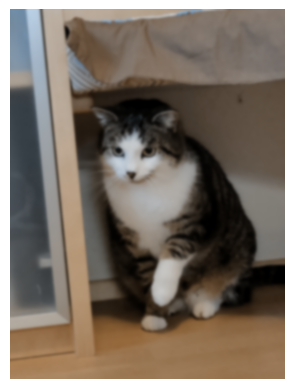

In [25]:
plot_blurred_image(image_path, sigma=10)

In [26]:
def sharpen_image(image_path, sharpening_filter=None, strength=2.0, grayscale:bool = False):
    if grayscale:
        image = cv2.cvtColor(imread(image_path), cv2.COLOR_RGB2GRAY)
    else:
        image = cv2.cvtColor(imread(image_path), cv2.COLOR_BGR2RGB)  # Added missing argument

    if sharpening_filter is None:
        sharpening_filter = strength * np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])

    if grayscale:
        sharpened_image = cv2.filter2D(image, -1, sharpening_filter)[1:-1, 1:-1]
    else:
        sharpened_image = np.zeros_like(image)
        for i in range(3):
            sharpened_image[..., i] = cv2.filter2D(image[..., i], -1, sharpening_filter)

    sharpened_image = sharpened_image[1:-1, 1:-1]

    if grayscale:
        plt.imshow(sharpened_image, cmap='gray')
    else:
        plt.imshow(cv2.cvtColor(sharpened_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

In [27]:
sharpen_image(image_path, grayscale=False, strength=2) # Bemerkbar vor allem bei geraden Linien

In [28]:
sharpen_image(image_path, grayscale=True, strength=2) # Bemerkbar vor allem bei geraden Linien

### Graustufen

Wurde bereits besprochen, ist aber ebenso in vielen Fällen ein essentieller Bestandteil der Data Augmentation Methodiken. 

### Resizing (Auflösung verringern)

Um den benötigten Speicherplatz zu verringern, werden oft Bilder herunterskaliert. Dies führt zu einfacheren Modellen, die schneller trainierbar sind (und normalerweise vergleichbare Performance bieten). Außerdem wird der Speicher auf der Festplatte bzw. der benötigte Speicher auf der GPU (oder RAM) verringert.

Außerdem benötigen die meisten Modelle, welche Bilder verarbeiten, eine fixe Eingangsgröße. Sprich Sie können nur mit Bildern der gleichen Größe arbeiten.

In [29]:
def resize_image(image_path, target_width, target_height):
    # Open an image file
    with Image.open(image_path) as img:
        resized_img = img.resize((target_width, target_height), Image.LANCZOS) # LANCZOS is the algorithm used for resizing
        return resized_img

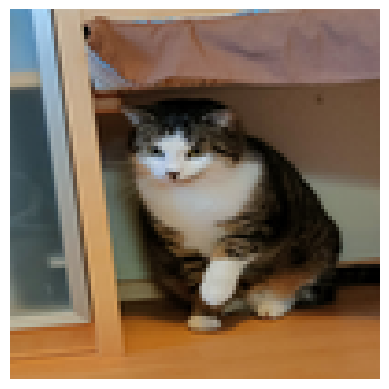

(100, 100)


In [30]:
resized_img = resize_image(image_path, target_width=100, target_height=100)
plt.imshow(resized_img)
plt.axis('off')
plt.show()
print(resized_img.size)

## Sequentielle Daten:

Neben den tabellarischen Daten und den Bildern ist eine weitere wichtige Datenquelle jene, welche sich mathematisch durch Folgen beschreiben lässt. Sie zeichnet sich darin aus, dass die verschiedenen Datenpunkte eine Reihenfolge besitzen. Eine bekannte Schreibweise für diese Daten ist:
$$(a_n)_{n\in\mathbb{N}} = a_1, a_2, a_3, \ldots .$$
Dabei steht der Subindex $i$ in $a_i$ für das $i$-te Element dieser Folge.

Es gibt hier auch mehrere Arten von sequentiellen Daten, wobei wir insbesondere die Tonspuren (Sound) und Daten in Textform genauer behandeln werden.

## Sequentielle Daten: Sound

Daten hier sind sehr ähnlich zu tabellarischen Daten mit nur einem (numerischen) Feature. Tonaufnahmen sind natürlich im Original (Analog) eine Funktion $f(x)$. Wir können diese aber nicht messen, sondern nur punktuelle Aufnahmen von $f(x)$ (Digitalisierungsvorgang). Somit haben wir auch hiere eine Folge $(a_n)_{n\in\mathbb{N}}$, wobei der Index $i$ im $a_i$ nun für den Zeitpunkt $i$ steht. Der Zeitabstand $t_S$ zwischen den Datenpunkten $a_i$ und $a_{i+1}$ ist konstant und ist bestimmt durch die Sampling-Frequency (Messfrequenz) $f_S$. Normalerweise beträgt die Messfrequenz in etwa $f_S = 48\, \text{kHz}$, was bedeutet, dass der Abstand zwischen 2 Samples $t_S=f_S^{-1} \approx 0.021\, \text{ms}$ beträgt.

Ein konstanter Ton bedeutet außerdem, dass sich die Funktion $f(x)$ aus der Summe von Sinusfunktionen (mit verschiedenen Frequenzen $f_i$ und Amplituden $a_i$) zusammensetzt. Sprich
$$f(x)=\sum_{i}a_i\sin(2\pi f_i x).$$

Dabei ändert die Frequenz den Ton, die Amplitude die Lautstärke.

Wir starten nun mit der Generierung von einer einzelnen Sinus-Funktion

In [31]:
def generate_sine(freq: float, signal_length: float, sampling_rate: int):
    t = np.linspace(0, signal_length, int(signal_length * sampling_rate), endpoint=False)
    return np.sin(2 * np.pi * freq * t)

Wir können uns diese Welle nun grafisch darstellen lassen (und auch auditiv)

In [32]:
def plot_signal(points: np.ndarray, time: float, sampling_rate: int, show_sampling_points:bool=False):
    n_samples = int(sampling_rate * time)
    t = np.linspace(0, time, n_samples, endpoint=False)

    plt.plot(t, points)
    if show_sampling_points:
        plt.plot(t, points, r'o')
    
    plt.show()

Anzahl der Punkte: 250


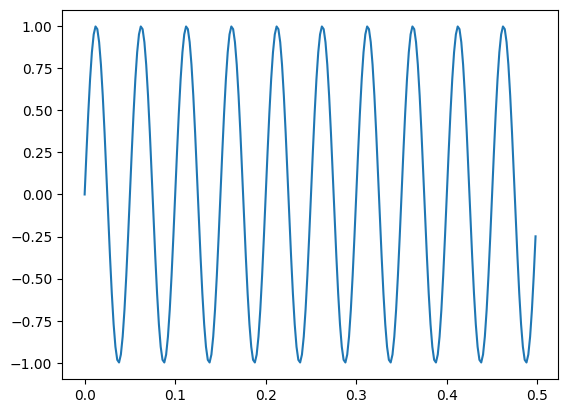

In [33]:
f = 20
T = 0.5
sampling_rate = 500

signal = generate_sine(f, T, sampling_rate)
print(f"Anzahl der Punkte: {len(signal)}")

plot_signal(signal, T, sampling_rate)
plot_signal(signal, T, sampling_rate, show_sampling_points=True)

Eine falsche (=zu kleine) Samplingrate führt zu einer Signalverfälschung, wie folgende Beispiele zeigen

In [34]:
def plot_signal_with_sampling_rate(points: np.ndarray, time: float, sampling_rate: int):
    
    t1 = np.linspace(0, time, len(points))
    plt.plot(t1, points)

    n_samples = np.ceil(sampling_rate * time).astype(int)
    t2 = [i / sampling_rate for i in range(n_samples)]

    idx = np.round(np.linspace(0, (len(points) / time) * t2[-1], n_samples, endpoint=True)).astype(int)
    sampled_points = points[idx]
    plt.plot(t2, sampled_points, 'o')
    plt.show()

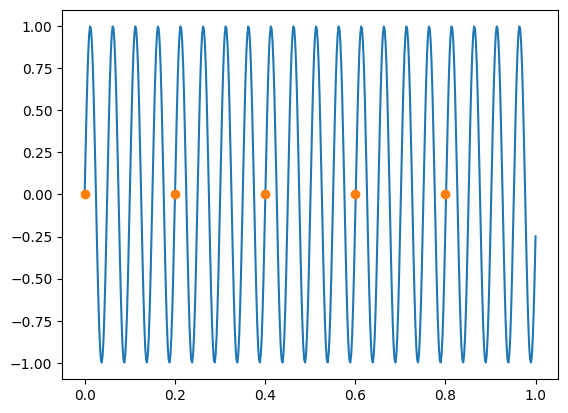

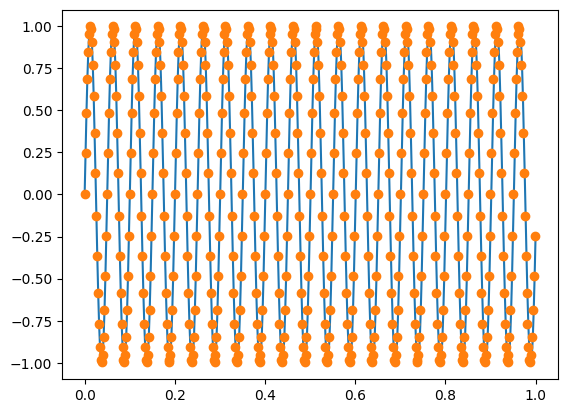

In [35]:
T = 1
f = 20
sampling_rate = 500

signal = generate_sine(f, T, sampling_rate)

plot_signal_with_sampling_rate(signal, T, sampling_rate = 5)
plot_signal_with_sampling_rate(signal, T, sampling_rate = 10)
plot_signal_with_sampling_rate(signal, T, sampling_rate = 20)
plot_signal_with_sampling_rate(signal, T, sampling_rate = 25)
plot_signal_with_sampling_rate(signal, T, sampling_rate = 500)

In [36]:
# Nun generieren wir einen Ton

T = 1
f = 440
sampling_rate = 24000

signal = generate_sine(f, T, sampling_rate)

ipd.Audio(signal, rate=sampling_rate)

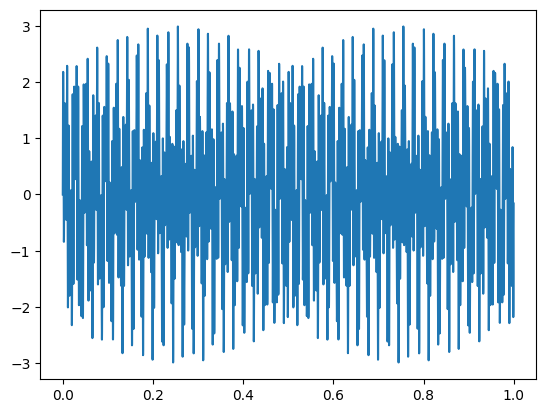

In [37]:
# Nun erstellen wir einen etwas komplizierteren Ton
T = 1
sampling_rate = 24000

signal_1 = generate_sine(44, T, sampling_rate)
signal_2 = generate_sine(240, T, sampling_rate)
signal_3 = generate_sine(330, T, sampling_rate)

signal = signal_1 + signal_2 + signal_3

plot_signal(signal, T, sampling_rate)
ipd.Audio(signal, rate=sampling_rate)

Zuguterletzt laden wir jetzt noch eine Wav-Datei visualisieren sie und spielen sie ab.

In [38]:
def read_wav_file(wav_file: str, time: int = None) -> Tuple[np.ndarray, int]:
    file = read(wav_file)
    signal_rate = file[0]
    points = file[1]
    # check for multiple channels (should only be stereo, i.e., 2 at max)
    if len(points.shape) > 1:
        points = points[:, 0]  # just take the first channel
    if time:
        length_of_signal = int(time * signal_rate)
        if length_of_signal < len(points):
            points = points[0:length_of_signal]
    return points, signal_rate

In [39]:
sound_path = os.path.join("..", "resources", "piano.wav")
T = 20
signal, sampling_rate = read_wav_file(sound_path, time=T)

t = np.linspace(0, T, len(signal))
plt.plot(t, signal)
plt.show()

ipd.Audio(signal, rate=sampling_rate)

Um im Machine Learning Bereich mit sequentiellen Daten zu arbeiten gibt es mehrere Möglichkeiten:
* Recurrent Neural Networks ((x)LSTM, Transformer, etc.)
* Features aus den Tonspuren berechnen und diese in ein normales Machine Learning Modell stecken

Für den letzteren Punkt sehen wir uns nun die **Fourier Transformation** an.
Sie zerlegt das Signal in die einzelnen Frequenzbestandteile, was *Spektrum* genannt wird. Wir verwenden dazu das `fft` Package von `scipy`.

In [40]:
def apply_fourier_transform(points: np.ndarray):
    points_fourier_transform = scipy.fft.rfft(points)
    winsize = len(points_fourier_transform) * 2 - 2
    freqs = scipy.fft.fftfreq(winsize)[:len(points_fourier_transform)]
    data = 2 * np.abs(points_fourier_transform) / len(points)
    return pd.Series(data, index=freqs)

def plot_spectrum(ft_points: Union[np.ndarray, pd.Series], sampling_rate: int, max_freq: float = None):
    if isinstance(ft_points, pd.Series):
        ft_points = ft_points.values
    winsize = len(ft_points) * 2 - 2
    freqs = scipy.fft.fftfreq(winsize)[:len(ft_points)] * sampling_rate
    if max_freq:
        max_bin = np.searchsorted(freqs, max_freq)
        freqs = freqs[:max_bin]
        ft_points = ft_points[:max_bin]
    plt.plot(freqs, ft_points)
    plt.show()

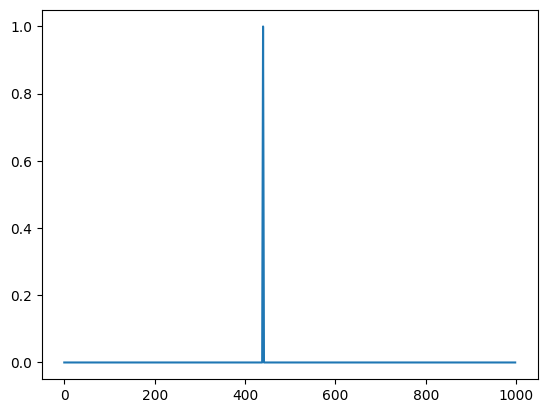

In [41]:
f = 440
T = 0.5
sampling_rate = 24000

signal = generate_sine(f, T, sampling_rate)

fourier_transform = apply_fourier_transform(signal)
plot_spectrum(fourier_transform, sampling_rate, max_freq=1000)

In [42]:
# Nun erstellen wir einen etwas komplizierteren Ton
T = 1
sampling_rate = 24000

signal_1 = generate_sine(180, T, sampling_rate)
signal_2 = generate_sine(240, T, sampling_rate)
signal_3 = generate_sine(330, T, sampling_rate)

signal = signal_1 + signal_2 + signal_3

In [43]:
fourier_transform = apply_fourier_transform(signal)
plot_spectrum(fourier_transform, sampling_rate, max_freq=500)

In [44]:
# Wir können auch die Fourier Transformation für die .wav Datei von vorher bestimmen.
sound_path = os.path.join("..", "resources", "piano.wav")
T = 20
signal, sampling_rate = read_wav_file(sound_path, time=T)

fourier_transform = apply_fourier_transform(signal)
plot_spectrum(fourier_transform, sampling_rate, max_freq=5000)

**Wichtig**:
* Das Spektrum macht nur bei konstanten Tönen einen Sinn
* In unserem Fall ändert sich aber der Ton laufend
* Abhilfe schafft hier ein **Spektrogramm**, welches quasi für jeden Zeitpunkt ein Spektrum berechnet (werden wir jetzt nicht näher behandeln)

## Sequentielle Daten: Text

Ein sehr aktuelles Thema in Zeiten von Large Language Models (LLM's) ist die Datenform als Text. Auch hier sind die Datenpunkte geordnet, was wiederum mit einer Folge $(a_n)_{n\in\mathbb{N}}$ modelliert werden kann. Dieses mal ist diese Folge aber keine Digitalisierung einer Funktion $f(x)$.

Wir werden uns nun etwas genauer mit Textverarbeitung beschäftigen. Sie ist das Hauptthema im Gebiet *Natural Language Processing* (NLP).

Wenn wir mit Text arbeiten, dann unterliegt dieser normalerweise einem Vokabular. Dieses basiert sehr stark auf der verwendeten Sprache. Außerdem ist dieses Vokabular sehr riesig, weswegen oft nur die $n$-meistverwendetsten Wörter genutzt werden (zBsp. $n=10000$).

Mit dieser Idee könnt nun jedes Wort in diesem Vokabular als *One-Hot*-Vektor dargestellt werden.

Annahme, wir wollen nun die Wörter $\{\text{Columbus},\text{ist},\text{ein},\text{lieber},\text{Kater}\}$ darstellen als One-Hot Vektoren.

In [45]:
vocabulary = ['Columbus', 'ist', 'ein', 'lieber', 'Kater']
sentence = 'Columbus ist ein lieber Hund'

In [46]:
def convert_to_onehot(vocab: list, sentence: str):
    words_sentence = sentence.split()
    words_vocab = np.unique(vocab)
    one_hot = np.zeros(shape=(len(words_sentence), len(words_vocab)), dtype=np.uint8)
    for i, word in enumerate(words_sentence):
        try:
            one_hot[i, vocab.index(word)] = 1
        except Exception as e:
            print(e) # Wort ist nicht im vocabulary
    return pd.DataFrame(data=one_hot, index=words_sentence)

In [47]:
convert_to_onehot(vocabulary, sentence)

'Hund' is not in list


0  1  2  3  4
Columbus  1  0  0  0  0
ist       0  1  0  0  0
ein       0  0  1  0  0
lieber    0  0  0  1  0
Hund      0  0  0  0  0

Da es aber nicht recht intuitiv, bzw. schnell unübersichtlich wird, wenn wir zBsp. beginnen mit $10000$-dimensionalen One-Hot Vektoren zu rechnen ($n$ kann auch viel größer sein), verwendet (und trainiert) man sogenannte **Word Embeddings**.

Diese sind kompakte Representationen von den Wörtern, in einem viel kleineren Raum. Sprich wir wandeln unsere Wörter von $\{0,1\}^n$ auf $[0,1]^m$ mit $m << n$ um.

Dieser neue Raum soll dafür auch ein paar Eigenschaften haben:
* Ähnliche Wörter sollen nahe beinander sein
* "Rechnen" mit Wörtern ist möglich (Cosine Similarity oder König-Mann+Frau $\approx$ Königin)


Im generellen kann man sich Embeddings so vorstellen, wie wenn der Inhalt von Wörtern/Sätzen kompakt repräsentiert wird als $n$-dimensionaler Vektor.

---

Wir verwenden nun so ein Modell, in diesem Fall `word2vec`.

Das Embedding kann dann mit dem Befehl `python -m spacy download en_core_web_md` heruntergeladen werden. Wir machen dies im Notebook, könnten es aber genauso in der *miniconda* Konsole machen.

Möglicherweise muss auch die Library `pydantic` erneut installiert werden (war bei mir der Fall), idealerweise mit `pip install pydantic==1.7.4` (Erst Relevant für die Textverarbeitung am Ende des Notebooks)

In [48]:
# download embedding 
!python -m spacy download en_core_web_md

/bin/bash: /home/tikaiz/miniconda3/envs/dsai/lib/libreadline.so.8: no version information available (required by /bin/bash)
/bin/bash: /home/tikaiz/miniconda3/envs/dsai/lib/libreadline.so.8: no version information available (required by /bin/bash)
/bin/bash: /home/tikaiz/miniconda3/envs/dsai/lib/libreadline.so.8: no version information available (required by /bin/bash)
/bin/bash: /home/tikaiz/miniconda3/envs/dsai/lib/libreadline.so.8: no version information available (required by /bin/bash)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.5/33.5 MB 15.1 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [49]:
# Nun laden wir dieses Embedding-Model
word_embedding_german = spacy.load('en_core_web_md')

In [50]:
# Nun können wir die Vektoren extrahieren von den vorigen Wörtern
columbus = word_embedding_german('Columbus')
_is = word_embedding_german('is')
a = word_embedding_german('a')
lovely = word_embedding_german('lovely')
cat = word_embedding_german('cat')

In [51]:
# Größe eines Vektors
print(columbus.vector.shape)

(300,)


In [52]:
print(columbus.vector)

[-0.61506    0.45745    0.34629   -0.42685    0.84782   -0.41435
  0.12422    0.13778    0.30993    1.2499    -1.2305    -0.20239
 -0.2944    -0.21408   -0.63358   -0.34638    0.30566    1.3755
  0.024425   0.16306   -0.04864   -0.61891    0.11519   -0.48656
 -0.10342    0.23771   -0.51147    0.37534   -0.12923    0.29566
 -0.36304   -0.06235    0.098723   0.34361   -0.085307   0.42652
  0.037085   0.31742   -0.74668    0.10692   -0.18141    0.40202
  0.56771   -0.11344    0.24492    0.22647    0.19766   -0.2177
  0.41926    0.048979  -0.13648    0.024594  -0.10012   -0.086374
 -0.12419    0.15195    0.20617    0.066046   0.25952    0.060823
 -0.30025    0.22363    0.39436    0.18966    0.10297    0.5493
 -0.16654    0.34562   -0.37017   -0.15314   -0.55936    0.11936
 -0.3041    -0.64677    0.80659    0.19804   -0.72554    0.3686
 -0.10039    0.061825  -0.35904    0.37567    0.27465    0.41907
 -0.15196    0.10567    1.5322     0.88811   -0.30164   -0.62204
  0.015519  -0.44977   -0.0

In [53]:
# Wir können nun aber auch noch die Ähnlichkeit zwischen den Wörtern berechnen
car = word_embedding_german('car')
bike = word_embedding_german('bike')
dog = word_embedding_german('dog')

In [54]:
car.similarity(bike)

0.22796432673931122

In [55]:
car.similarity(dog)

0.19304995238780975

In [56]:
# Nun verwenden wir noch einige Beispielwörter und lassen uns diese später visualisieren
beispiel_woerter = ['dog', 'cat', 'cow', 'jeans', 'dress', 'happy', 'nice', 'king', 'queen', 'woman', 'man', 'school', 'teacher', 'student']

dataframe_embeddings = pd.DataFrame(data=[word_embedding_german(word).vector for word in beispiel_woerter], index=beispiel_woerter)

In [57]:
dataframe_embeddings

0         1         2         3         4         5         6    \
dog     -0.72483  0.425380  0.025489 -0.398070  0.037463 -0.298110 -0.282790   
cat     -0.72483  0.425380  0.025489 -0.398070  0.037463 -0.298110 -0.282790   
cow     -0.95603  0.141260 -0.028987  0.000202 -0.094250  0.685630  0.252780   
jeans   -0.64995 -0.120890  0.037206 -0.263410  0.286470  0.575020  0.486520   
dress   -0.90833  0.187590 -0.483800  0.646020  0.571520 -0.632710  0.025627   
happy   -0.71589  0.342390 -0.776760  0.262120 -0.103790  0.367260  0.467000   
nice    -0.73351  0.413920 -0.442500 -0.291270 -0.096179  0.097562  0.131510   
king    -0.60644 -0.512050  0.006492 -0.291940 -0.565150 -0.115230  0.077274   
queen   -1.12090 -0.288090  0.123360 -0.216080 -0.098690 -0.241770  0.070938   
woman   -0.62299 -0.313320 -0.014659  0.144490 -0.143000 -0.611890  0.009913   
man     -0.60482  0.373990  0.284460 -0.016269 -0.118930 -0.197060 -0.351180   
school  -0.65605  0.483440 -0.083531  0.338010  0.095574 -0.056138  0.347310   
teacher -0.65605  0.483440 -0.083531  0.338010  0.095574 -0.056138  0.347310   
student -0.96802 -0.019952 -0.276190 -0.192280  0.194890 -0.077457 -0.423130   

              7         8        9    ...       290       291       292  \
dog      0.293330  0.577750  1.22050  ...  0.019095 -0.342830 -0.586020   
cat      0.293330  0.577750  1.22050  ...  0.019095 -0.342830 -0.586020   
cow     -0.293350  0.097644  1.30080  ...  0.190610 -0.153820 -0.189270   
jeans    0.050770  0.127320  0.47011  ... -0.344500  0.206400  0.464560   
dress   -0.101550  0.063692  0.29793  ...  0.651420  0.080100  0.450930   
happy   -0.144060  0.577090  2.59080  ... -0.539270 -0.068958 -0.599250   
nice    -0.518250  0.106710  2.41440  ... -0.304850  0.186480 -0.270480   
king     0.335610  0.115930  2.35160  ... -0.712360  0.294900 -0.214790   
queen   -0.274450 -0.200250  1.33570  ...  0.545290  0.087036 -0.527260   
woman    0.105850 -0.216510  1.18710  ...  0.321240  0.064128  0.486100   
man     -0.065699 -0.218660  3.22520  ... -0.284210 -0.209050 -0.240500   
school   0.291710 -0.429500  1.48490  ...  0.432600 -0.057419 -0.026134   
teacher  0.291710 -0.429500  1.48490  ...  0.432600 -0.057419 -0.026134   
student -0.284030  0.140500  2.65290  ... -0.850620  0.823750  0.158610   

              293       294       295       296       297       298       299  
dog      0.009563 -0.085052  0.833120  0.319780  0.050317 -0.231590  0.281650  
cat      0.009563 -0.085052  0.833120  0.319780  0.050317 -0.231590  0.281650  
cow     -0.398270 -0.384530  0.194640  0.056178  0.157380  0.233600  0.034716  
jeans   -0.509310  0.366480  0.418830  0.675610  0.488660 -0.261030 -0.498360  
dress    0.408230  0.307260 -0.350350  0.197770 -0.556100  0.013015 -0.367050  
happy    0.022476  0.488180 -0.004069  0.412400 -0.311280 -0.192970  0.242070  
nice    -0.111110  0.126810  0.395380 -0.056084 -0.187770 -0.076822 -0.015507  
king     0.256580 -0.193580  1.105700  0.228620  0.218590 -0.190440 -0.102530  
queen   -0.328620  0.138660  0.366820 -0.053972 -0.009001 -0.197320 -0.127800  
woman   -0.507630  0.155070  0.047091 -0.081585 -0.482580  0.049814 -0.402190  
man     -0.156590 -0.381150 -0.340890 -0.672440 -0.136010  0.303780 -0.084864  
school   0.498960  0.313360  0.458440 -0.554270 -0.226080  0.265790 -0.154570  
teacher  0.498960  0.313360  0.458440 -0.554270 -0.226080  0.265790 -0.154570  
student  0.100800  0.599730 -0.261220  0.307910  0.072593 -0.121590  0.130530  

[14 rows x 300 columns]

In [58]:
# 2D Scatter Plot inklusive Beschriftung der Wörter mit Hilfe von PCA

# Hier passieren ein paar Dinge, die wir noch nicht im Detail kennen gelernt haben. Wir werden unter anderem PCA noch im Sommersemester kennen lernen.

pca = PCA(n_components=2)
dataframe_embeddings_pca = pca.fit_transform(dataframe_embeddings)

plt.figure(figsize=(10, 10))
plt.scatter(dataframe_embeddings_pca[:, 0], dataframe_embeddings_pca[:, 1])
for i, word in enumerate(beispiel_woerter):
    plt.annotate(word, (dataframe_embeddings_pca[i, 0], dataframe_embeddings_pca[i, 1]))
plt.show()

Funktioniert es gut?

Mögliche Gründe:
* Zu kleine Dimension im Embedding Space
* Schlecht trainiertes Embedding
* Wörter sind vielleicht nicht so ähnlich wie geglaubt
* Dimensionsreduzierung scheitert

In [59]:
# Abschließend können wir noch die Wörter in den Beispiel Wörtern finden, welche am ähnlichsten zu einem gegebenen Wort sind

def find_similar_words(query: np.ndarray, data: pd.DataFrame):
    norms = data.apply(np.square).sum(axis=1).apply(np.sqrt)
    data = data.apply(lambda x: x / norms).dot(query).sort_values()
    similar = data.index[:-4:-1].to_list()
    distant = data.index[:3].to_list()
    return similar, distant

In [60]:
word = 'cat'

similar, distant = find_similar_words(word_embedding_german(word).vector, dataframe_embeddings)

In [61]:
print(similar)
print(distant)

['dog', 'cat', 'cow']
['student', 'teacher', 'school']


## `Glob` Package

Abschließend wollen wir noch kurz diskutieren, wie man Dateien rekursiv in einem Ordner suchen kann. Dafür verwenden wir das `glob` Package.

In [62]:
# Alle Jupyter-Notebooks in dem Über-Übergeoardneten Ordner finden

path = os.path.join("..", "..", "**", "*.ipynb")
file_list = glob.glob(path, recursive=True) # recursive = True hier sehr wichtig, ansonsten keine Dateien

In [63]:
for file in file_list:
    print(file)

../../01_Python_Jupyter/code/00/einfuehrung_jupyter.ipynb
../../02_daten_tabellarisch/code/daten_tabellarisch_1.ipynb
../../02_daten_tabellarisch/code/daten_tabellarisch_2.ipynb
../../02_daten_tabellarisch/code/daten_tabellarisch_3.ipynb
../../02_daten_tabellarisch/code/daten_tabellarisch_4.ipynb
../../02_daten_tabellarisch/code/daten_tabellarisch_5.ipynb
../../03_Visualisierungen/code/visualisierung_1.ipynb
../../03_Visualisierungen/code/visualisierung_2.ipynb
../../03_Visualisierungen/code/visualisierung_3.ipynb
../../03_Visualisierungen/code/visualisierung_4.ipynb
../../04_weitere_datenformen/code/datenformen_1.ipynb
